In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
import xgboost
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,classification_report,accuracy_score,roc_auc_score
from collections import Counter
%matplotlib inline 


#### 1. Merging Data and adding additional columns for Class, Gender 

In [ ]:
class file_opr:
    counter = 1
    def __init__(self,path):
        self.path = path
    def merge_gender(self):
       file_list = os.listdir(self.path)
       male_files=[]
       female_files = []
       for file in file_list:
           
           if file[-1] == 'M':
               df_path = os.path.join(self.path,file)
               df = pd.read_csv(df_path,header=None)
               male_files.append(df)
           elif file[-1]=='F':
                df_path = os.path.join(self.path,file)
                #print(df_path)
                df = pd.read_csv(df_path,header=None)
                female_files.append(df)
           else:
               print('Not a vaild file')
               continue 
       male_tmp_df = pd.concat(male_files)
       #print(male_tmp_df.head())
       #print(male_files)
       #print(female_files)

       female_temp_df = pd.concat(female_files,axis = 0)
       #print(female_temp_df.head())
       male_tmp_df['sex'] = 0 #encoding for male
       female_temp_df['sex'] = 1 #encoding for female
       final_df = pd.concat([male_tmp_df,female_temp_df])
       final_df.to_csv(f'Merged_{file_opr.counter}.csv')
       file_opr.counter = file_opr.counter +1
       
S1_path = 'D:\INEURON\TASKS_Class\CLustering_fastrack\Datasets_Healthy_Older_People\S1_Dataset'
opr = file_opr(S1_path)
opr.merge_gender()
S2_path = 'D:\INEURON\TASKS_Class\CLustering_fastrack\Datasets_Healthy_Older_People\S2_Dataset'
opr2 = file_opr(S2_path)
opr.merge_gender()

df_1 = pd.read_csv('D:\INEURON\TASKS_Class\CLustering_fastrack\Merged_1.csv',header=None)
df_2 = pd.read_csv('D:\INEURON\TASKS_Class\CLustering_fastrack\Merged_2.csv',header=None)
data = pd.concat([df_1,df_2])
data.drop([0],axis=1,inplace=True)
col_names = ['Time','G_frontal','G_vertical','G_lateral','ID_antenna','RSSI','Phase','Frequency','Label','Sex']
data.columns = col_names
data.to_csv("data.csv")

In [2]:
data = pd.read_csv("data.csv",index_col=False)
data.head()

,Unnamed: 0,Time,G_frontal,G_vertical,G_lateral,ID_antenna,RSSI,Phase,Frequency,Label,Sex
0,0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,0
1,1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,0
2,2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,0
3,3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,0
4,4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,0


In [3]:
data.columns

Index(['Unnamed: 0', 'Time', 'G_frontal', 'G_vertical', 'G_lateral',
       'ID_antenna', 'RSSI', 'Phase', 'Frequency', 'Label', 'Sex'],
      dtype='object')

In [4]:
data.drop(["Unnamed: 0"],axis='columns',inplace=True)

C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


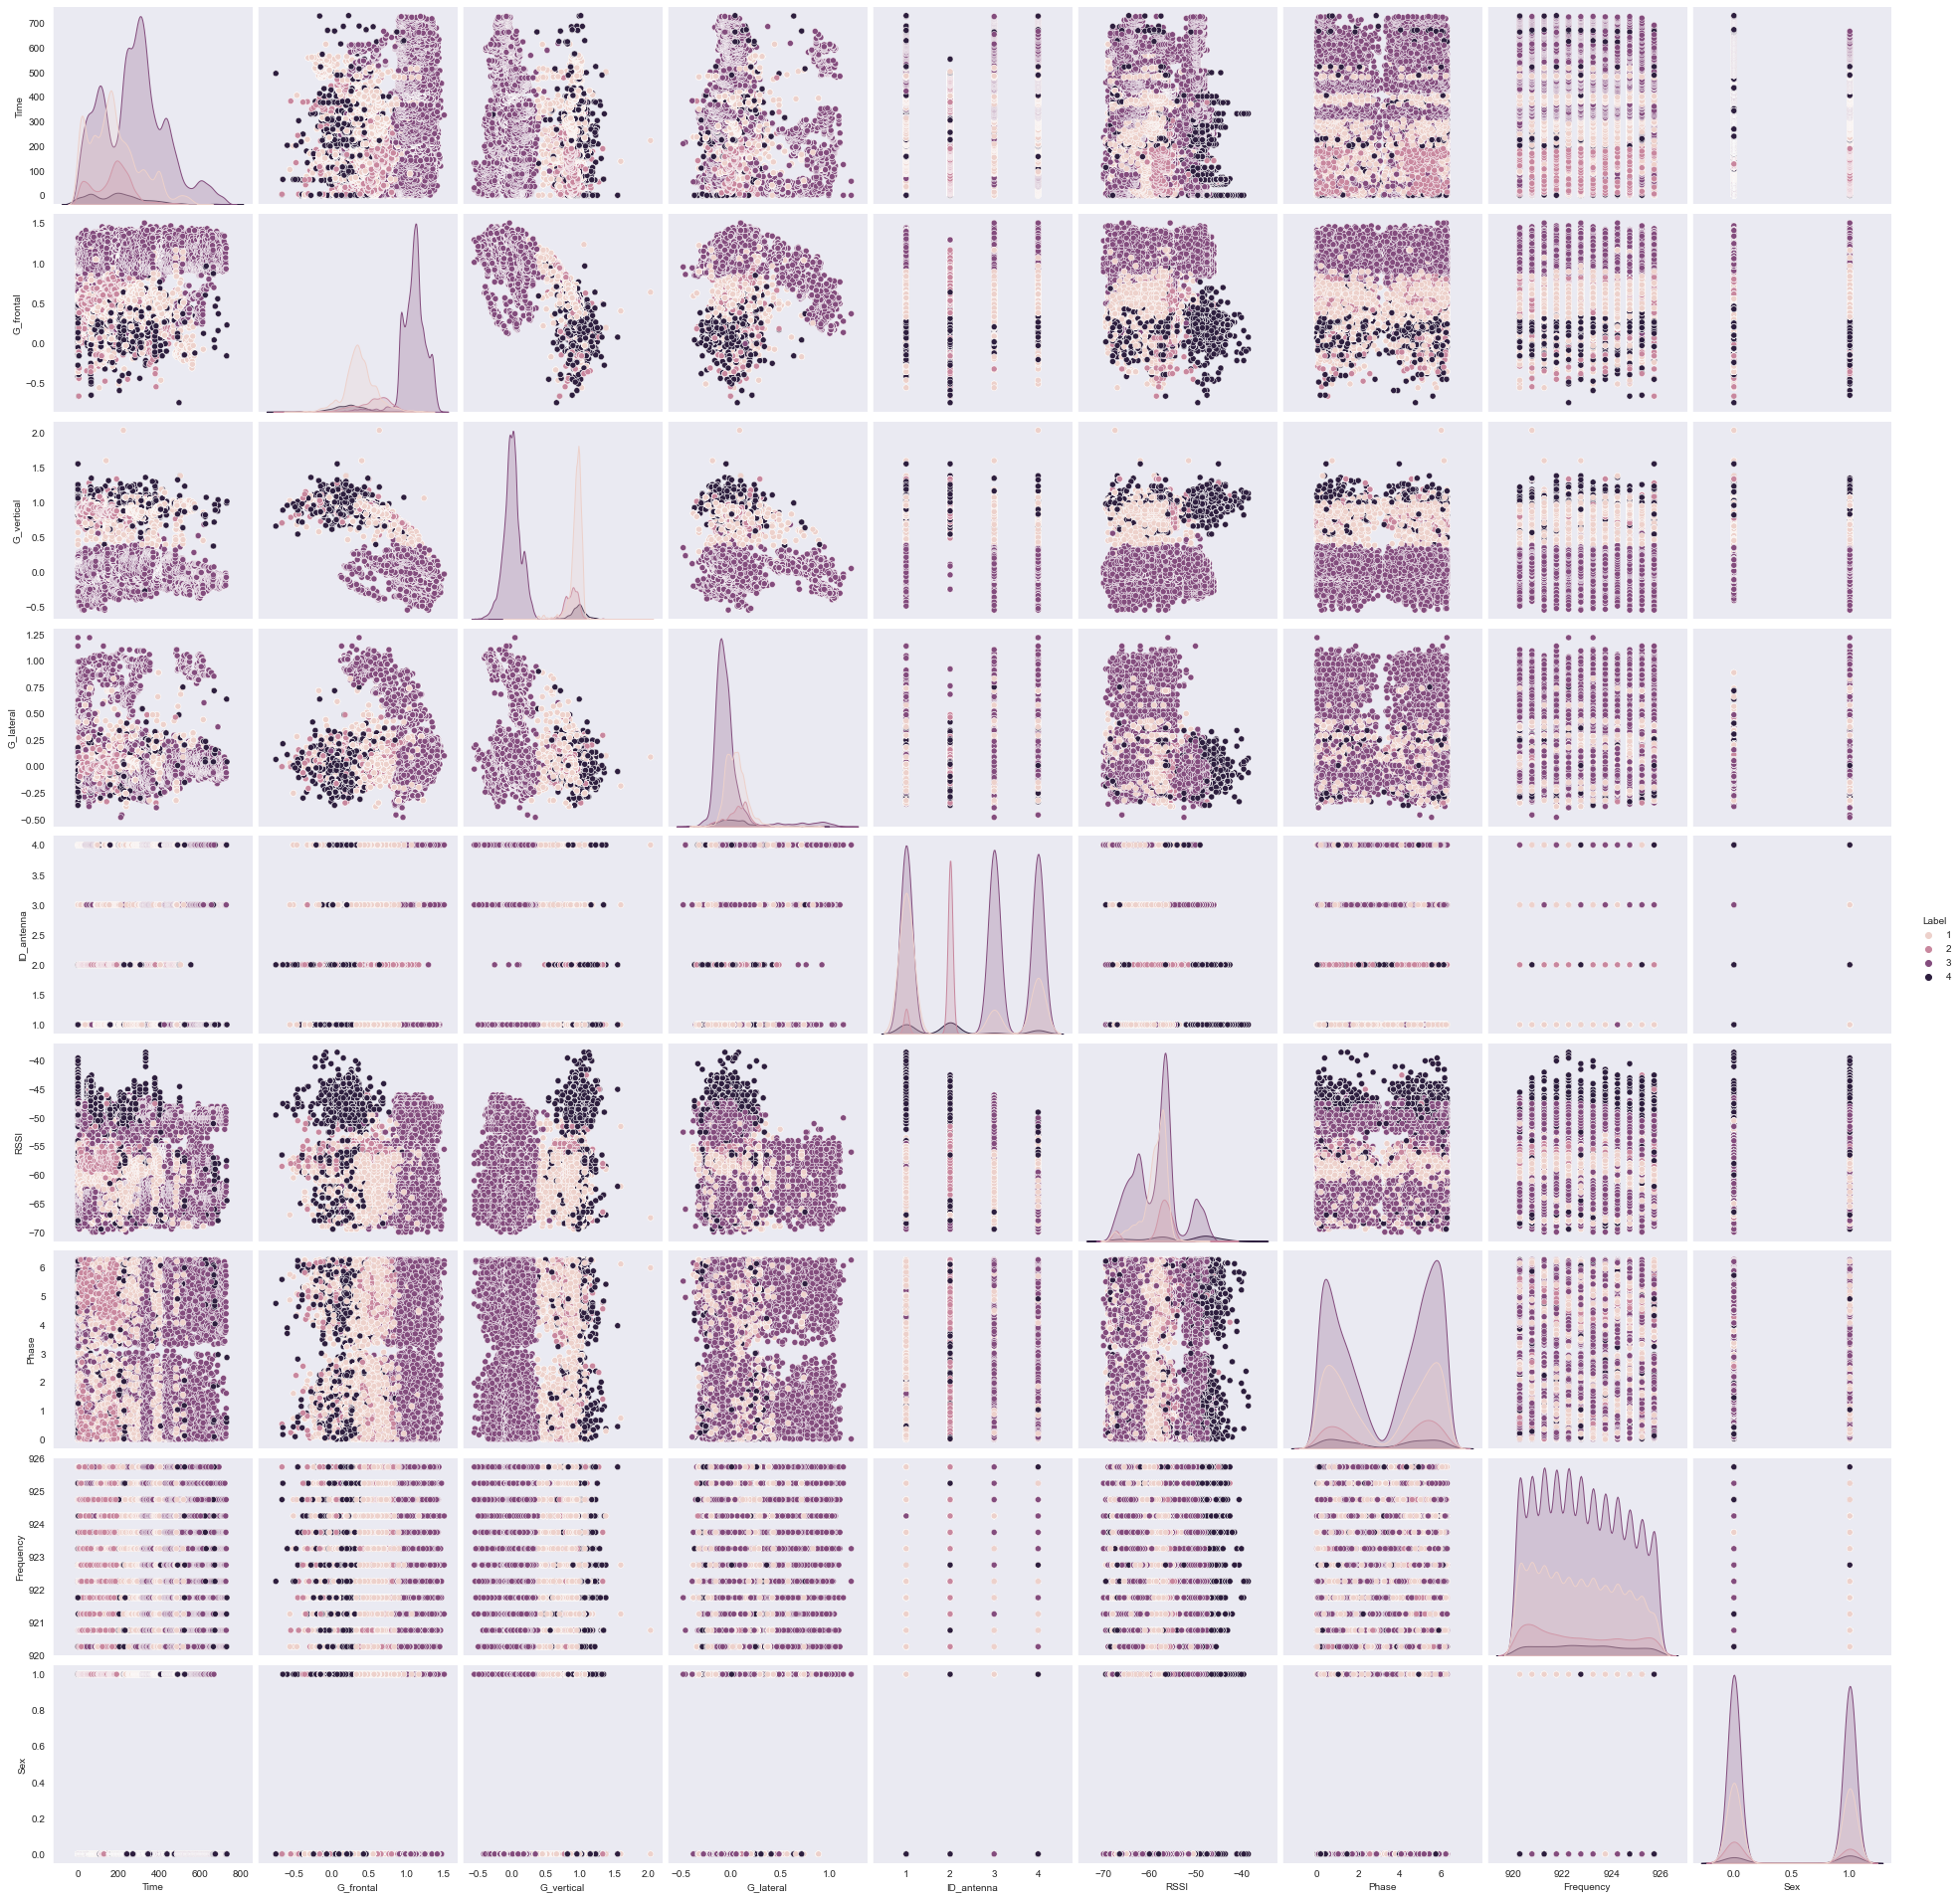

In [7]:
sns.set_style('dark')
sns.pairplot(data,hue='Label',size=3)
plt.show()

Since there is no clear separation depicted by any of the pair, we cannot drop features. However, feattures like sex, frequency, phase should be dropped for faster training as they donot contribute to any trend 

In [13]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
med = data.median()
IQR = q3 - q1
upper_limit = q3 + (1.5*IQR)
lower_limit = q1 - (1.5*IQR)

#### Percentage of data in beyond the Upper limit

In [14]:
((data>upper_limit).sum()/len(data)*100).sort_values(ascending=False)

G_lateral     4.106170
RSSI          3.957547
Time          1.227087
G_frontal     0.000000
G_vertical    0.000000
ID_antenna    0.000000
Phase         0.000000
Frequency     0.000000
Label         0.000000
Sex           0.000000
dtype: float64

#### Percentage of data below the lower limit 

In [16]:
((data<lower_limit).sum()/len(data)*100).sort_values(ascending=False)

G_lateral     0.127663
RSSI          0.057162
G_frontal     0.009527
Time          0.000000
G_vertical    0.000000
ID_antenna    0.000000
Phase         0.000000
Frequency     0.000000
Label         0.000000
Sex           0.000000
dtype: float64

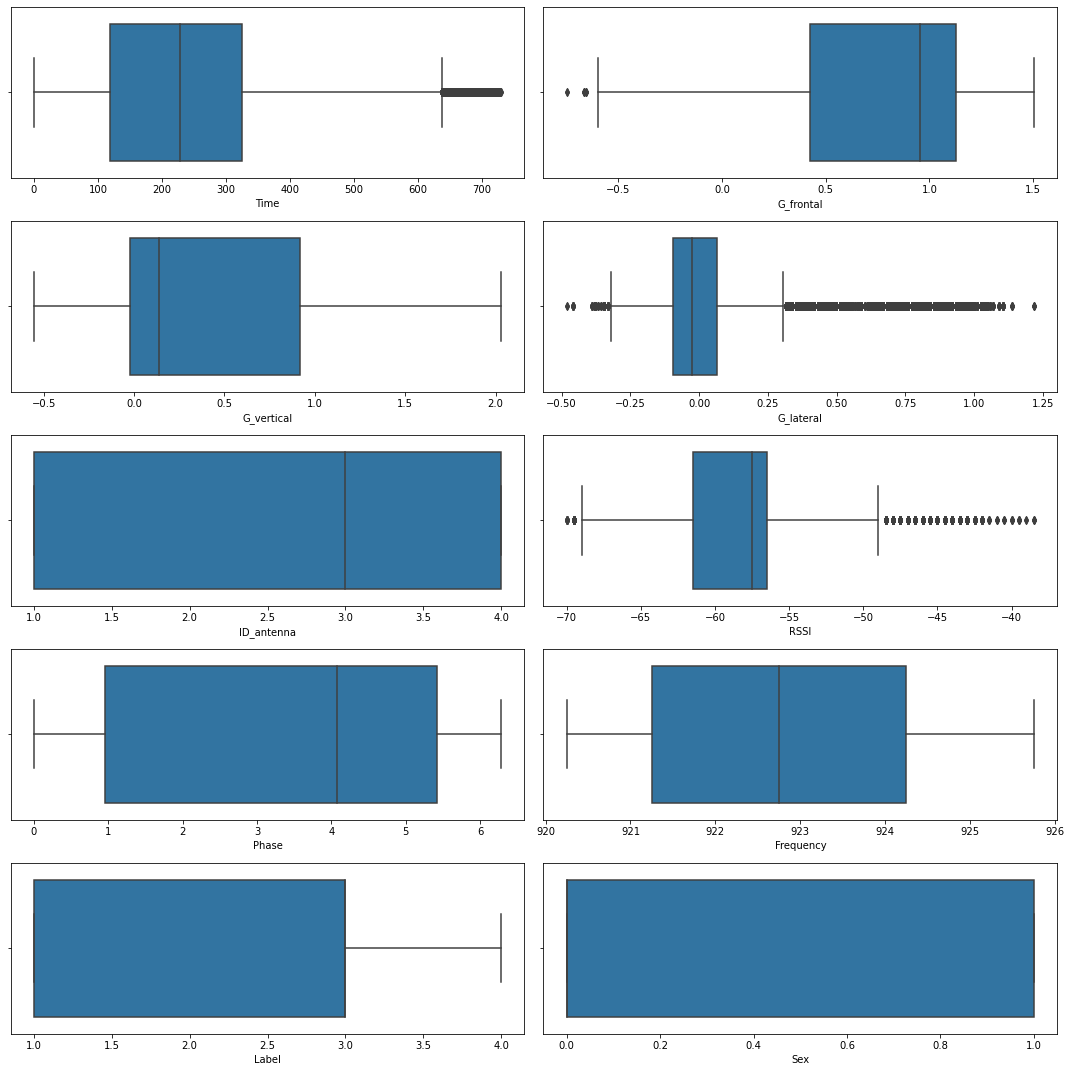

In [32]:
#box plot with wishkers at 1.5 times IQR

fig, ax  = plt.subplots(figsize=(15,15),nrows=5,ncols=2)
for i,col in enumerate(data.columns):
    sns.boxplot(x = data[col],ax= ax[i//2,i%2],whis=1.5)
plt.tight_layout(pad=1.1)

Since the precentage of data in the outliars zone is not large, hence removal of outliars shall be avoided to prevent data loss for training and validating the model. 

### 1. Splitting data into x,y and dropping features that are not necessary for the training 

In [34]:
x,y = data.drop(["Label","Time","Sex","Phase","Frequency","ID_antenna"],axis='columns'), data["Label"]

#### 1. Standardizing the features 

In [35]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))

In [36]:
x.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [37]:
x.isna().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [38]:
#No data in the features are null or nan. 
x.columns = ['G_frontal','G_vertical','G_lateral','RSSI']

In [39]:
x.head()

,G_frontal,G_vertical,G_lateral,RSSI
0,-1.344773,1.344430,-0.497101,-1.099326
1,-1.344773,1.344430,-0.497101,-0.990894
2,-0.901033,1.148565,-0.118415,-1.099326
3,-0.901033,1.148565,-0.118415,-0.990894
4,-1.167282,1.246519,-0.370873,-1.099326


In [40]:
#Train - Test - Split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

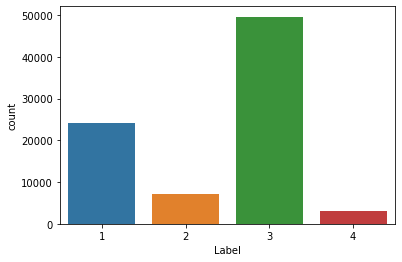

In [43]:
sns.countplot(y_train)

In [16]:
print("Count of Classes : {}".format(Counter(y_train)))


Count of Classes : Counter({3: 49595, 1: 24231, 2: 7022, 4: 3123})


### 3. Over Sampling using SMOTE

Count of Classes BEFORE Oversampling : Counter({3: 49595, 1: 24231, 2: 7022, 4: 3123})
Count of Classes AFTER Oversampling : Counter({1: 49595, 2: 49595, 3: 49595, 4: 49595})


C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

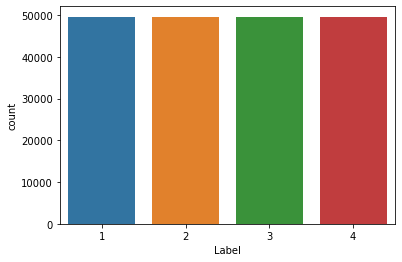

In [48]:
sm = SMOTE() 

x_ov_train,y_ov_train = sm.fit_resample(x_train,y_train)
print("Count of Classes BEFORE Oversampling : {}".format(Counter(y_train)))
print("Count of Classes AFTER Oversampling : {}".format(Counter(y_ov_train)))
sns.countplot(y_ov_train)

#### Logitic Regression

In [54]:
logi_clf = LogisticRegression(multi_class='ovr')
logi_clf.fit(x_ov_train,y_ov_train)
logi_pred = logi_clf.predict(x_test)
logi_predict_proba = logi_clf.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,logi_pred))
print("Test F1 Score : ",f1_score(y_test,logi_pred,average='micro'))
print("Train F1 Score: ",f1_score(y_ov_train,logi_clf.predict(x_ov_train),average='micro'))
print("AUC ROC Score: ",roc_auc_score(y_test,logi_predict_proba,multi_class='ovr'))

Classification Report : 
                precision    recall  f1-score   support

           1       0.91      0.46      0.61      6093
           2       0.39      0.71      0.50      1740
           3       1.00      1.00      1.00     12371
           4       0.23      0.67      0.34       789

    accuracy                           0.81     20993
   macro avg       0.63      0.71      0.61     20993
weighted avg       0.89      0.81      0.82     20993

Test F1 Score :  0.8069356452150717
Train F1 Score:  0.7043048694424842
AUC ROC Score:  0.9421823812776224


#### Decision Tree

In [53]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_ov_train,y_ov_train)
tree_pred = tree_clf.predict(x_test)
tree_predict_proba = tree_clf.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,tree_pred))
print("Test F1 Score : ",f1_score(y_test,tree_pred,average='micro'))
print("Train F1 Score: ",f1_score(y_ov_train,tree_clf.predict(x_ov_train),average='micro'))
print("AUC ROC Score: ",roc_auc_score(y_test,tree_predict_proba,multi_class='ovr'))

Classification Report : 
                precision    recall  f1-score   support

           1       0.99      0.99      0.99      6093
           2       0.97      0.96      0.97      1740
           3       1.00      1.00      1.00     12371
           4       0.96      0.97      0.96       789

    accuracy                           0.99     20993
   macro avg       0.98      0.98      0.98     20993
weighted avg       0.99      0.99      0.99     20993

Test F1 Score :  0.9921402372219311
Train F1 Score:  0.998265954229257
AUC ROC Score:  0.9917293386166679


#### K-Nearest Neighbour

In [55]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_ov_train,y_ov_train)
knn_pred = knn_clf.predict(x_test)
knn_predict_proba = knn_clf.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,knn_pred))
print("Test F1 Score : ",f1_score(y_test,knn_pred,average='micro'))
print("Train F1 Score: ",f1_score(y_ov_train,knn_clf.predict(x_ov_train),average='micro'))
print("AUC ROC Score: ",roc_auc_score(y_test,knn_predict_proba,multi_class='ovr'))

Classification Report : 
                precision    recall  f1-score   support

           1       0.98      0.96      0.97      6093
           2       0.91      0.96      0.93      1740
           3       1.00      1.00      1.00     12371
           4       0.92      0.96      0.94       789

    accuracy                           0.98     20993
   macro avg       0.95      0.97      0.96     20993
weighted avg       0.98      0.98      0.98     20993

Test F1 Score :  0.98370885533273
Train F1 Score:  0.9938653090029237
AUC ROC Score:  0.9914071989986415


#### Support Vector CLassifier

In [56]:
svc_clf = SVC()
svc_clf.fit(x_ov_train,y_ov_train)
svc_pred = svc_clf.predict(x_test)




AttributeError: predict_proba is not available when  probability=False

In [57]:
print("Classification Report : \n ",classification_report(y_test,svc_pred))
print("Test F1 Score : ",f1_score(y_test,svc_pred,average='micro'))
print("Train F1 Score: ",f1_score(y_ov_train,svc_clf.predict(x_ov_train),average='micro'))
#print("AUC ROC Score: ",roc_auc_score(y_test,svc_predict_proba,multi_class='ovr'))

Classification Report : 
                precision    recall  f1-score   support

           1       0.91      0.77      0.83      6093
           2       0.55      0.83      0.66      1740
           3       1.00      1.00      1.00     12371
           4       0.63      0.71      0.67       789

    accuracy                           0.91     20993
   macro avg       0.77      0.83      0.79     20993
weighted avg       0.92      0.91      0.91     20993

Test F1 Score :  0.906206830848378


KeyboardInterrupt: 

### ***Model Summary*** 

In [70]:
models = [logi_clf,tree_clf,knn_clf]

def eval_score_report(model=[]):
    try:
        f1_scores_test = []
        f1_scores_train = []
        accuracy_scores_test = []
        accuracy_scores_train = []
        AUC_scores = []


        for model in models:
            f1_scores_test.append(f1_score(y_test,model.predict(x_test),average='micro'))
            f1_scores_train.append(f1_score(y_ov_train,model.predict(x_ov_train),average='micro'))
            accuracy_scores_test.append(accuracy_score(y_test,model.predict(x_test)))
            accuracy_scores_train.append(accuracy_score(y_ov_train,model.predict(x_ov_train)))
            AUC_scores.append(roc_auc_score(y_test,model.predict_proba(x_test),multi_class='ovr'))
        result = pd.DataFrame([f1_scores_test,f1_scores_train,accuracy_scores_test,accuracy_scores_train,AUC_scores],columns=[str(i)for i in models],index=[['f1_scores_test','f1_scores_train','accuracy_scores_test','accuracy_scores_train','AUC_scores']])
        return result
    except Exception as e :
        return e
    
eval_score_report(models)
    

,LogisticRegression(multi_class='ovr'),DecisionTreeClassifier(),KNeighborsClassifier()
f1_scores_tes,0.806936,0.992140,0.983709
f1_scores_train,0.704305,0.998266,0.993865
accuracy_scores_test,0.806936,0.992140,0.983709
accuracy_scores_train,0.704305,0.998266,0.993865
AUC_scores,0.942182,0.991729,0.991407


### Ensemble Techniques

#### Random Forest

In [21]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_ov_train,y_ov_train)
rf_pred = rf_clf.predict(x_test)
rf_predict_proba = rf_clf.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,rf_pred))
print("f1 Score: ",f1_score(y_test,rf_pred,average = "micro"))
print("Accuracy Score : ",accuracy_score(y_test,rf_pred))
print("AUC ROC Score: ",roc_auc_score(y_test,rf_predict_proba,multi_class='ovr'))

Classification Report : 
                precision    recall  f1-score   support

           1       1.00      1.00      1.00      6093
           2       1.00      1.00      1.00      1740
           3       1.00      1.00      1.00     12371
           4       0.99      0.96      0.97       789

    accuracy                           1.00     20993
   macro avg       0.99      0.99      0.99     20993
weighted avg       1.00      1.00      1.00     20993

f1 Score:  0.9977611584813986
Accuracy Score :  0.9977611584813986
AUC ROC Score:  0.9996109601529706


#### Adaboost 

In [22]:
ada_clf = AdaBoostClassifier()
ada_clf.fit(x_ov_train,y_ov_train)
ada_pred = ada_clf.predict(x_test)
ada_predict_proba = ada_clf.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,ada_pred))
print("f1 Score: ",f1_score(y_test,ada_pred,average = "micro"))
print("Accuracy Score : ",accuracy_score(y_test,ada_pred))
print("AUC ROC Score: ",roc_auc_score(y_test,ada_predict_proba,multi_class='ovr'))


Classification Report : 
                precision    recall  f1-score   support

           1       0.83      0.60      0.70      6093
           2       0.40      0.87      0.54      1740
           3       0.99      0.97      0.98     12371
           4       0.70      0.58      0.64       789

    accuracy                           0.84     20993
   macro avg       0.73      0.76      0.71     20993
weighted avg       0.89      0.84      0.85     20993

f1 Score:  0.8406611727718764
Accuracy Score :  0.8406611727718764
AUC ROC Score:  0.9128806242661054


### Hyper parameter tuning of above algorithms

1. Logistic Regression 

In [30]:
logi_clf = LogisticRegression()

params = {
    "penalty" : ['l1','l2','elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
    
}
cv = StratifiedKFold(n_splits=10,shuffle=False)

grid = GridSearchCV(logi_clf,param_grid = params,n_jobs=-1,cv = cv,scoring='f1_micro')
grid.fit(x_ov_train,y_ov_train)
best_params = grid.best_params_
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhishek Mazumdar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", lin

nan (nan) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.700711 (0.002889) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
nan (nan) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.714215 (0.002697) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.714250 (0.002697) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.714291 (0.002664) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.700706 (0.002896) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.714266 (0.002623) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.714235 (0.002618) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
nan (nan) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
nan (nan) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
nan (nan) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
nan (nan) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'sag'}


***It is evident from that f1_scores (micro weighted) that Logistic regression is not a good algorithm for this particular usecase.*** 

#### 2. Decision Tree

    As decision tree by default is giving good f1_score and accuracy score, but there is a small amout of overfitting with respect to accuracy. Hence we will try to get the ccp_alpha values of tree to better generalize the tree 

In [40]:
tree_clf = DecisionTreeClassifier()
path = tree_clf.cost_complexity_pruning_path(x_ov_train,y_ov_train)
ccp_alpha = path.ccp_alphas
ccp_alpha


array([0.00000000e+00, 9.97087397e-08, 1.41470123e-07, 3.83970851e-07,
       3.35381924e-06, 5.01484707e-06, 5.02144292e-06, 5.03683957e-06,
       6.01647539e-06, 6.61092555e-06, 7.54150394e-06, 9.07349531e-06,
       9.60158234e-06, 9.73401796e-06, 9.74560608e-06, 9.78514200e-06,
       9.79361399e-06, 9.87591326e-06, 9.89263031e-06, 9.98916915e-06,
       9.99969673e-06, 1.00116499e-05, 1.00182548e-05, 1.00301587e-05,
       1.00442527e-05, 1.00493484e-05, 1.00526495e-05, 1.00526912e-05,
       1.00547062e-05, 1.00618178e-05, 1.00805642e-05, 1.34238641e-05,
       1.35194694e-05, 1.37881546e-05, 1.49190506e-05, 1.49592998e-05,
       1.49644174e-05, 1.49780580e-05, 1.50110242e-05, 1.50843035e-05,
       1.51637581e-05, 1.64556534e-05, 1.72828482e-05, 1.74748799e-05,
       1.77911673e-05, 1.88110041e-05, 1.88191014e-05, 1.89063885e-05,
       1.89413033e-05, 1.89413033e-05, 1.92468082e-05, 1.95332191e-05,
       1.95429130e-05, 1.96715346e-05, 1.98407097e-05, 1.98668035e-05,
      

Text(0, 0.5, 'score')

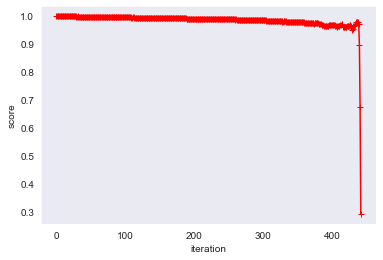

In [42]:
tree_models = []
score = []
for i in ccp_alpha:
    dt_m = DecisionTreeClassifier(ccp_alpha = i)
    dt_m.fit(x_ov_train,y_ov_train)
    tree_models.append(dt_m)
    score.append(dt_m.score(x_test, y_test))

    
plt.plot(score, 'r-+')
plt.xlabel('iteration')
plt.ylabel('score')

In [48]:
train_score = [i.score(x_ov_train,y_ov_train) for i in tree_models]
test_score = [i.score(x_test,y_test) for i in tree_models]





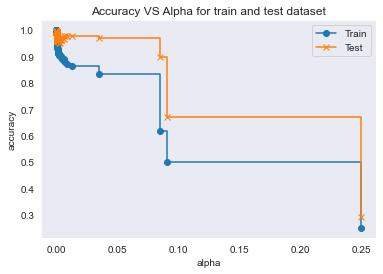

In [50]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy VS Alpha for train and test dataset")
ax.plot(ccp_alpha,train_score,marker='o',label = 'Train',drawstyle='steps-post')
ax.plot(ccp_alpha,test_score,marker = 'x',label = 'Test',drawstyle='steps-post')
ax.legend()
plt.show()

It is evident from the graph that there is no requirement of pruning operation. Hence, the default value of ccp_alpha will be utilized 

Hyper parameter tunning 

In [52]:
criterion = ['gini','entropy']
splitter = ['random','best']
max_depth = range(2,50,1)


param = dict(criterion=criterion, splitter = splitter,max_depth=max_depth)

tree_clf = DecisionTreeClassifier()
cv = StratifiedKFold()
grid = GridSearchCV(tree_clf,param_grid=param, cv = cv,n_jobs=-1)
grid.fit(x_ov_train,y_ov_train)
grid.best_params_


{'criterion': 'gini', 'max_depth': 45, 'splitter': 'best'}

In [56]:
tree_clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=45)
tree_clf.fit(x_ov_train,y_ov_train)
print("Train Score : ",tree_clf.score(x_ov_train,y_ov_train))
print("Test Score : ",tree_clf.score(x_test,y_test))
print("F1 Train Score : ",f1_score(y_ov_train,tree_clf.predict(x_ov_train),average='micro'))
print("F1 Test Score : ",f1_score(y_test,tree_clf.predict(x_test),average='micro'))

Train Score :  0.9994757536041939
Test Score :  0.9978564283332539
F1 Train Score :  0.9994757536041939
F1 Test Score :  0.9978564283332539


#### 3. KNearestNeighbors

In [57]:
knn_model = KNeighborsClassifier()

n_neighbors = range(1,30,2)
metric = ['euclidean','manhattan','minkowski']
weights = ['uniform','distance']
param = dict(n_neighbors=n_neighbors,metric=metric,weights=weights)
cv = StratifiedKFold()
grid = GridSearchCV(knn_model,param_grid=param,cv=cv,n_jobs=-1)
grid.fit(x_ov_train,y_ov_train)
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [58]:
knn_model = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights= 'distance')
knn_model.fit(x_ov_train,y_ov_train)
knn_predict = knn_model.predict(x_test)
knn_predict_proba = knn_model.predict_proba(x_test)
print("Classification Report : \n ",classification_report(y_test,knn_pred))
print("f1 Score: ",f1_score(y_test,knn_pred,average = "micro"))
print("Accuracy Scores---> train= {}, test = {}  ".format(knn_model.score(x_ov_train,y_ov_train),knn_model.score(x_test,y_test)))
print("AUC ROC Score: ",roc_auc_score(y_test,knn_predict_proba,multi_class='ovr'))


Classification Report : 
                precision    recall  f1-score   support

           1       0.99      0.99      0.99      6093
           2       0.99      1.00      0.99      1740
           3       1.00      1.00      1.00     12371
           4       0.95      0.96      0.95       789

    accuracy                           1.00     20993
   macro avg       0.98      0.99      0.99     20993
weighted avg       1.00      1.00      1.00     20993

f1 Score:  0.9953317772590864
Accuracy Scores---> train= 0.9992791612057668, test = 0.9970466345924832  
AUC ROC Score:  0.9952217835778411


## Notes:

As per the model evaluations observed for variuos models. The Ideal Models can be used are:
1. KNeighbor classifier, provided the dataset is small in size as the model will take up a lot of space
2. RandomForest, with a very minimal overfitting of 0.1% can be the best model for current prediction model. 

Also, because of limited hardware capabilities and long runtime SVC model was not utilized in this current project